In [1]:
#dependencies
import numpy as np
import tensorflow as tf
import helper

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.3.0'

In [3]:
PAD = 0
EOS = 1

vocab_size = helper.vocab_size
input_embedding_size = vocab_size * 2

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'encoder_inputs')
encoder_inputs_length = tf.placeholder(shape = (None,), dtype = tf.int32, name = 'encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype = tf.int32, name = 'decoder_targets')
decoder_targets_length = encoder_inputs_length

In [5]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype = tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)


In [6]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple

In [7]:
encoder_cell = LSTMCell(encoder_hidden_units)

In [8]:

((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
    )

In [9]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)
encoder_final_state_c = tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
encoder_final_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h), 1)
encoder_final_state = LSTMStateTuple(c = encoder_final_state_c, h = encoder_final_state_h)

In [10]:
decoder_cell = LSTMCell(decoder_hidden_units)

In [11]:

ecoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [12]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype = tf.float32)

In [13]:
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [14]:
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [15]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_targets_length)
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [16]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis=1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_targets_length)
    finished = tf.reduce_all(elements_finished)
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    state = previous_state
    output = previous_output
    loop_state = None
    
    return (elements_finished,
           input,
           state,
           output,
           loop_state)

In [17]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

In [18]:
decoder_outputs_ta, decoder_final_state,_ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [19]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1,decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [20]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [21]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)
learning_rate = 5e-3
#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
batch_size = 1000
batches = helper.generate_sequence(8, batch_size)
for b in next(batches)[:10]:
    print(helper.decode(b))

By the w
ay, toge
ther wit
h this p
ost I am
 also re
leasing 
code on 
Github t
hat allo


In [24]:
def next_feed():
    batch = next(batches)
    input_batch = batch[:-1]
    output_batch = batch[1:]
    encoder_inputs_, encoder_input_lengths_ = helper.batch(input_batch)
    decoder_targets_,_ = helper.batch(output_batch)
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_
    }

In [25]:
loss_track = []

In [26]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, out, pred) in enumerate(zip(fd[encoder_inputs].T, fd[decoder_targets].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input          > {}'.format(inp))
                print('    decode input   > {}'.format(helper.decode(inp)))
                print('    output         > {}'.format(out))
                print('    decode output  > {}'.format(helper.decode(out)))
                print('    predicted      > {}'.format(pred))
                print('    decode predict > {}'.format(helper.decode(pred)))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 3.8551406860351562
  sample 1:
    input          > [37  4 30 22 38 17 30 39]
    decode input   > By the w
    output         > [27  4 19 30 22 34 10 17]
    decode output  > ay, toge
    predicted      > [26 23 22 20  5 14 38 12]
    decode predict > RNt;rlhI
  sample 2:
    input          > [27  4 19 30 22 34 10 17]
    decode input   > ay, toge
    output         > [22 38 17  5 30 39 11 22]
    decode output  > ther wit
    predicted      > [ 4  4  2  2 16 16 16 23]
    decode predict > yySS’’’N
  sample 3:
    input          > [22 38 17  5 30 39 11 22]
    decode input   > ther wit
    output         > [38 30 22 38 11 40 30 31]
    decode output  > h this p
    predicted      > [ 8 23 23  6 20  6 26 20]
    decode predict > GNNf;fR;

batch 1000
  minibatch loss: 2.3935910576255992e-05
  sample 1:
    input          > [37  4 30 22 38 17 30 39]
    decode input   > By the w
    output         > [27  4 19 30 22 34 10 17]
    decode output  > ay, toge
    pre

loss 0.0000 after 3001000 example (batch_size=1000)


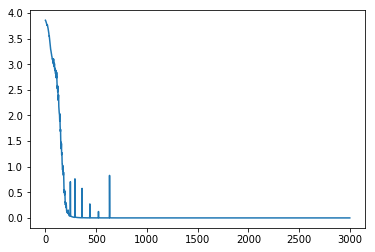

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} example (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [35]:
# test


init_input = [[helper.char_to_ix[ch] for ch in helper.data[:8]]]
strings = helper.decode(init_input[0])
def next_feed(previous_output):
    encoder_inputs_, encoder_input_lengths_ = helper.batch(previous_output)
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
    }
max_batches = 3001
batches_in_epoch = 1000

try:
    previous_output = init_input
    for batch in range(max_batches):
        fd = next_feed(previous_output)
        predict_ = sess.run(decoder_prediction, fd)
        for pred in predict_.T:
            strings += helper.decode(pred)
        previous_output = predict_.T
    print(strings)
except KeyboardInterrupt:
    print('training interrupted')

By the way, together with this post I am also releasing code on Github that allows you to train character-level language models based on multi-layer LSTMs. You give it a large chunk of text and it will learn to generate text like it one character at a time. You can also use it to reproduce my experiments below. But we’re getting ahead of ourselves; What are RNNs anyBy the way, together with this post I am also releasing code on Github that allows you to train character-level language models based on multi-layer LSTMs. You give it a large chunk of text and it will learn to generate text like it one character at a time. You can also use it to reproduce my experiments below. But we’re getting ahead of ourselves; What are RNNs anyBy the way, together with this post I am also releasing code on Github that allows you to train character-level language models based on multi-layer LSTMs. You give it a large chunk of text and it will learn to generate text like it one character at a time. You ca